# Vertical momentum flux [uw] by healpix zoom

## Uses uxarray 

Equatorial 10S-10N belt average, time-height display

---------------

In [48]:
### Import Packages: so many, gathered here 

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import easygems.healpix as egh

import uxarray as ux 
import hvplot.xarray

-------------
# Catalog of hackathon datasets 
--------------

In [2]:
import intake
# catalogue from which node? 
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["NCAR"]

In [3]:
list(cat)
# cat.ERA5.discover()

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'mpas_dyamond1',
 'mpas_dyamond2',
 'mpas_dyamond3',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3',
 'wrf_conus',
 'wrf_samerica']

-------------------
# Momentum flux [uw] in mpas_dyamond 1 & 2 datasets 

In [66]:
ZOOMLEVEL=5  # mpas_dyamond goes up to 10 

ds = cat.mpas_dyamond2(zoom=ZOOMLEVEL).to_dask()
ds

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 6GB
Dimensions:                 (time: 329, cell: 12288, nVertLevels: 55,
                             nSoilLevels: 4, nVertLevelsP1: 56)
Coordinates:
  * cell                    (cell) float64 98kB nan 1.0 ... 1.229e+04 1.229e+04
  * nSoilLevels             (nSoilLevels) float64 32B nan 1.0 2.0 3.0
  * nVertLevels             (nVertLevels) float64 440B nan 1.0 2.0 ... 53.0 54.0
  * nVertLevelsP1           (nVertLevelsP1) float64 448B nan 1.0 ... 54.0 55.0
  * time                    (time) datetime64[ns] 3kB 2020-01-20 ... 2020-03-01
Data variables: (12/19)
    air_temperature         (time, cell, nVertLevels) float32 889MB dask.array<chunksize=(1, 12288, 55), meta=np.ndarray>
    h_oml                   (time, cell) float32 16MB dask.array<chunksize=(1, 12288), meta=np.ndarray>
    hu_oml                  (time, cell) float32 16MB dask.array<chunksize=(1, 12288), meta=np.ndarray>
    hv_oml                  (time, cell) float32 16MB dask.array<chunksize=(1, 12288), meta=np.ndarray>
    pressure                (time, cell, nVertLevels) float32 889MB dask.array<chunksize=(1, 12288, 55), meta=np.ndarray>
    relhum                  (time, cell, nVertLevels) float32 889MB dask.array<chunksize=(1, 12288, 55), meta=np.ndarray>
    ...                      ...
    tslb                    (time, cell, nSoilLevels) float32 65MB dask.array<chunksize=(1, 12288, 4), meta=np.ndarray>
    uReconstructMeridional  (time, cell, nVertLevels) float32 889MB dask.array<chunksize=(1, 12288, 55), meta=np.ndarray>
    uReconstructZonal       (time, cell, nVertLevels) float32 889MB dask.array<chunksize=(1, 12288, 55), meta=np.ndarray>
    vegfra                  (time, cell) float32 16MB dask.array<chunksize=(1, 12288), meta=np.ndarray>
    w                       (time, cell, nVertLevelsP1) float32 906MB dask.array<chunksize=(1, 12288, 56), meta=np.ndarray>
    xice                    (time, cell) float32 16MB dask.array<chunksize=(1, 12288), meta=np.ndarray>

In [24]:
# Find the tropopause! from air_temperature, or pressure 
# At cell 0, time 0, tropopause looks like level 40 or so 
# ds['pressure'][1][0].plot(size=2, aspect=1.5);

In [25]:
# Quick healpix plot of w at level 40 near tropopause
# egh.healpix_show(ds['w'][1,:,50], vmin=-0.05, vmax=0.05, cmap='RdBu_r');  #, cbar=True);

In [89]:
def plot_equatorial_uw(dataset='mpas_dyamond1', ZOOMLEVEL=4):

    ds = cat[dataset](zoom=ZOOMLEVEL).to_dask()
    
    uxds = ux.UxDataset.from_healpix(ds)
    u = uxds['uReconstructZonal']
    w  = uxds['w'][:, :, 1:].rename({"nVertLevelsP1" : "nVertLevels"})
    uw = (u * w)
    
    # Equatorial belt only, zonal mean is just mean of faces 
    uw_eq = uw.cross_section.constant_latitude_interval((-10, 10))
    u_eq  =  u.cross_section.constant_latitude_interval((-10, 10))

    # uw_za = uw.isel(time=1, nVertLevels=40).zonal_average((-10, 10, 0.5))
    
    uwtot = uw_eq.mean(dim='n_face')
    uwtot = uwtot.to_xarray().compute()

    utot = u_eq.mean(dim='n_face')
    utot = utot.to_xarray().compute()

    # Make a Z-like (logp * 8km) coordinate 
    Zlogp = 8 *np.log(1.e5/ds['pressure'][1][0][1:])
    
    plt.figure(figsize=(13,5))
    plt.pcolormesh( uwtot.time, Zlogp.values, uwtot.transpose(), vmin=-0.1,vmax=0.1,cmap='RdBu_r' ); 
    plt.colorbar();

    plt.contour( utot.time, Zlogp.values, utot[:,1:].transpose(), levels=         np.arange(10)*5, colors='red'); 
    plt.contour( utot.time, Zlogp.values, utot[:,1:].transpose(), levels=np.flip(-np.arange(10))*5, colors='blue'); 

    plt.title(dataset+' time-height [uw] and [U], 10S-10N belt, healpix=' + str(ZOOMLEVEL) );
    plt.ylabel('Z from logp (km, approx.)')

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 5min 4s, sys: 1min 17s, total: 6min 21s
Wall time: 50.1 s


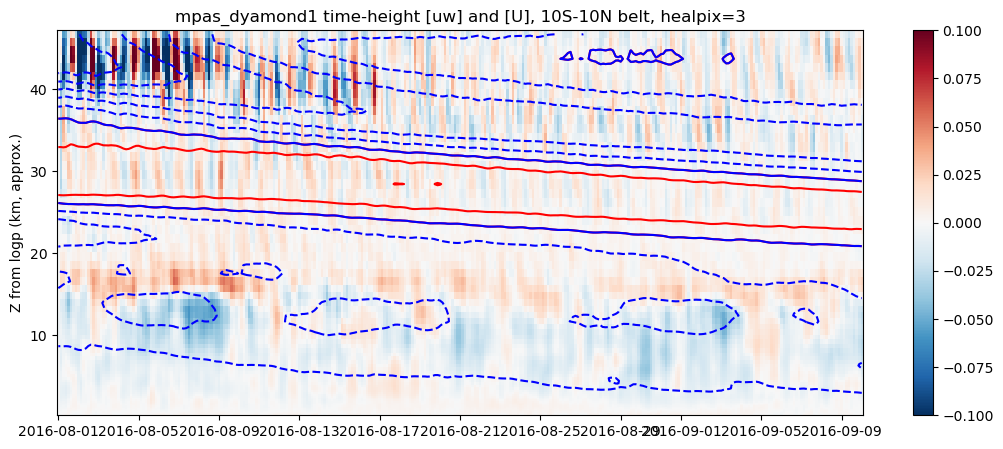

In [90]:
%%time
plot_equatorial_uw(dataset='mpas_dyamond1', ZOOMLEVEL=3)

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 5min 18s, sys: 1min 31s, total: 6min 49s
Wall time: 1min 4s


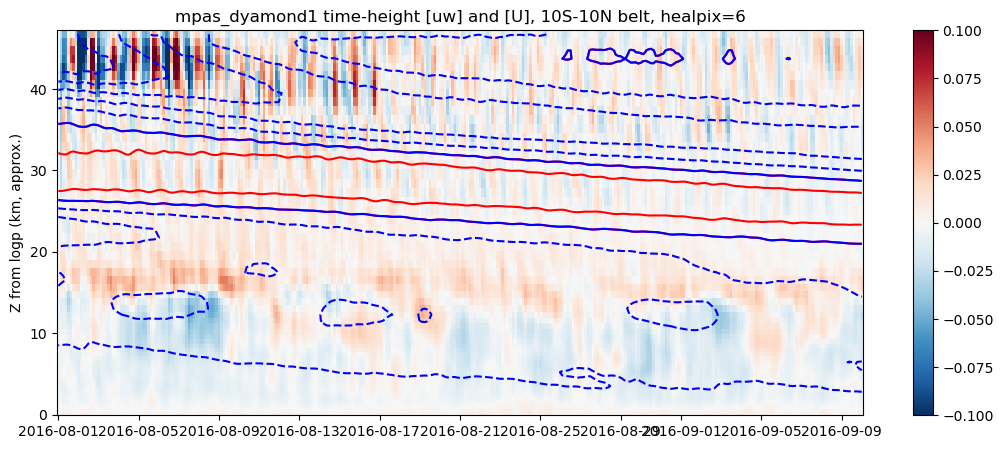

In [92]:
%%time
plot_equatorial_uw(dataset='mpas_dyamond1', ZOOMLEVEL=6)

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 29min 37s, sys: 18min 39s, total: 48min 16s
Wall time: 16min 51s


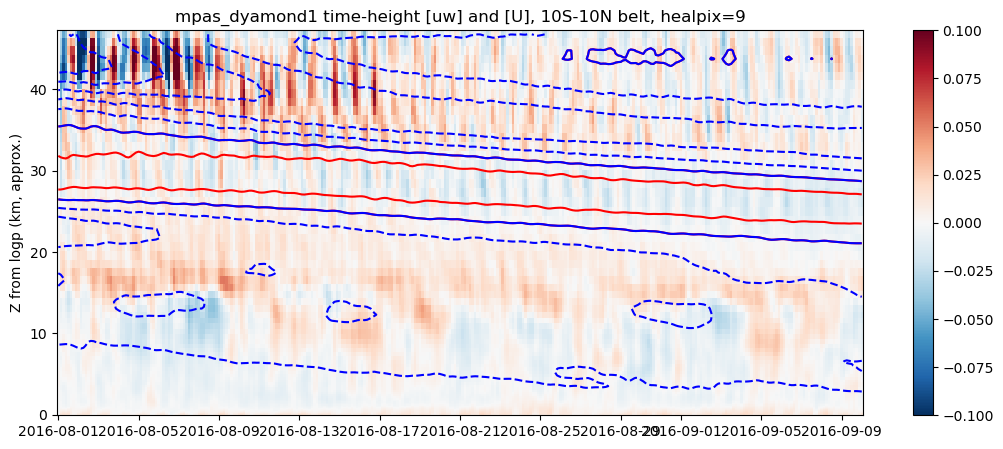

In [93]:
%%time
plot_equatorial_uw(dataset='mpas_dyamond1', ZOOMLEVEL=9)

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 2h 2min 54s, sys: 1h 10min 58s, total: 3h 13min 52s
Wall time: 1h 10min 10s


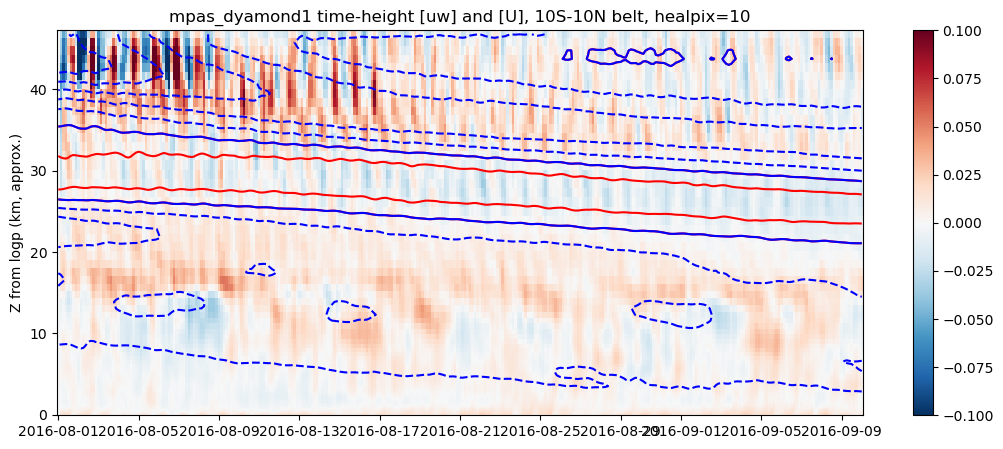

In [97]:
%%time
plot_equatorial_uw(dataset='mpas_dyamond1', ZOOMLEVEL=10)

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 3min 48s, sys: 58.2 s, total: 4min 46s
Wall time: 37.7 s


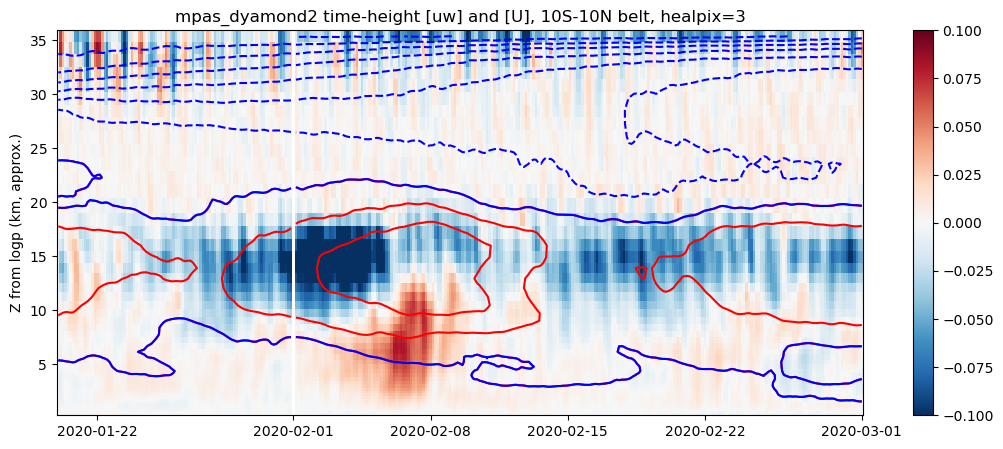

In [91]:
%%time
plot_equatorial_uw(dataset='mpas_dyamond2', ZOOMLEVEL=3)

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 3min 58s, sys: 1min 7s, total: 5min 5s
Wall time: 51.3 s


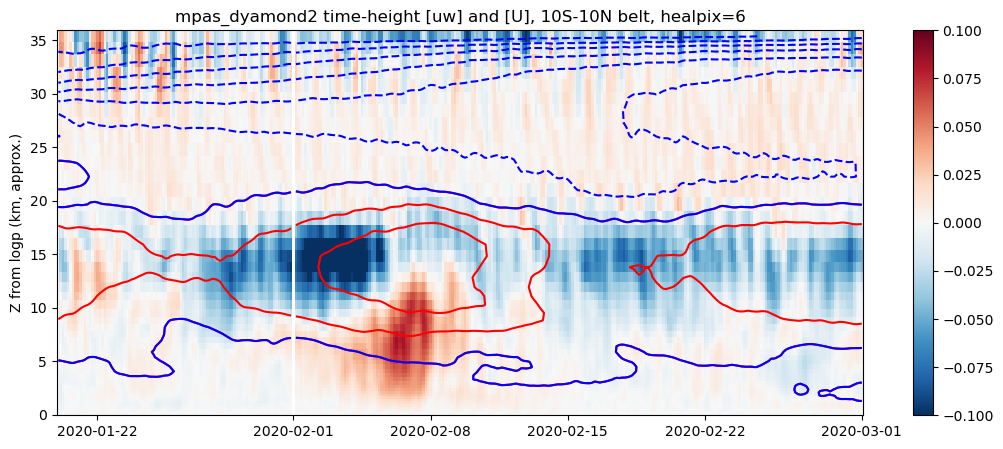

In [94]:
%%time
plot_equatorial_uw(dataset='mpas_dyamond2', ZOOMLEVEL=6)

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 22min 32s, sys: 14min 22s, total: 36min 54s
Wall time: 13min 57s


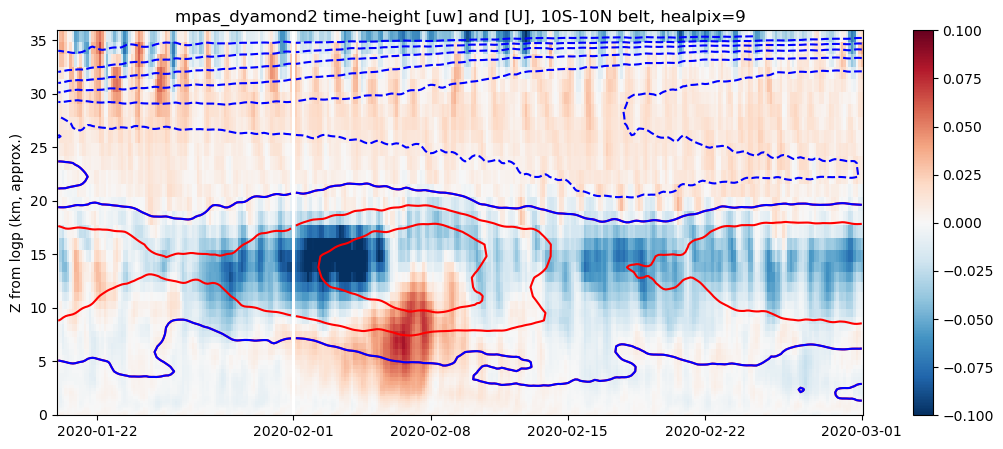

In [95]:
%%time
plot_equatorial_uw(dataset='mpas_dyamond2', ZOOMLEVEL=9)

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 1h 32min 42s, sys: 57min 37s, total: 2h 30min 19s
Wall time: 52min 28s


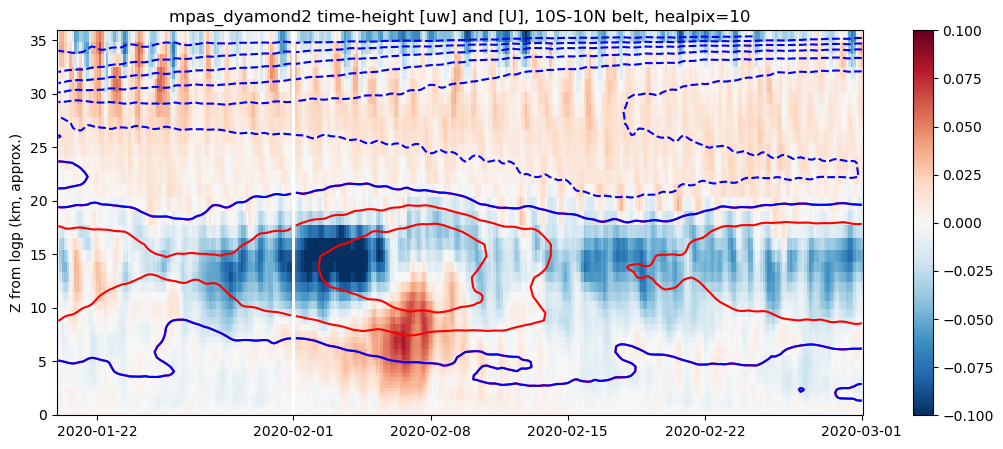

In [96]:
%%time
plot_equatorial_uw(dataset='mpas_dyamond2', ZOOMLEVEL=10)

In [19]:
# Quicklook 
#(uw_eq.isel(time=1, nVertLevels=40).plot(backend='bokeh', ylim=(-10, 10), colorbar=False, features=["coastline"]) + uw_za.plot.line(x="zonal_mean", y="latitudes", ylim=(-10, 10), width=250)).opts()
#(uw_eq.isel(time=1, nVertLevels=40).plot(backend='bokeh', ylim=(-10, 10), colorbar=False) + uw_za.plot.line(x="zonal_mean", y="latitudes", ylim=(-10, 10), width=250)).opts()